# Climate Analysis
examining the cleaned data to determine preciptation, station reporting, and temperature 

In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import matplotlib.pyplot as plt
from matplotlib import pyplot
import datetime as dt
import numpy as np
import pandas as pd

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")
inspector = inspect(engine)

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)    
Base.classes.keys()

['measurement', 'stations']

In [4]:
stations = Base.classes.stations
measurement = Base.classes.measurement

In [5]:
session = Session(engine)

In [6]:
for field in inspector.get_columns(table_name='measurement'):
    print(field ['name'], field['type'])

id INTEGER
station VARCHAR(15)
date VARCHAR(10)
prcp FLOAT
tobs INTEGER


In [7]:
for field in inspector.get_columns(table_name='stations'):
    print(field ['name'], field['type'])

id INTEGER
station VARCHAR(15)
name VARCHAR(200)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# date is string, as seen above, run query to view date format
session.query(measurement.date).first()

('2010-01-01')

# Precipitation Analysis

In [9]:
# query one year into a DataFrame and correct to datetime type
prcp = pd.DataFrame(session.query(measurement.date,measurement.prcp).\
                    filter(measurement.date >= '2016-01-01', measurement.date < '2017-01-01').all())
prcp.date = pd.to_datetime(prcp.date, format='%Y-%m-%d').dt.date
prcp = prcp.set_index('date')

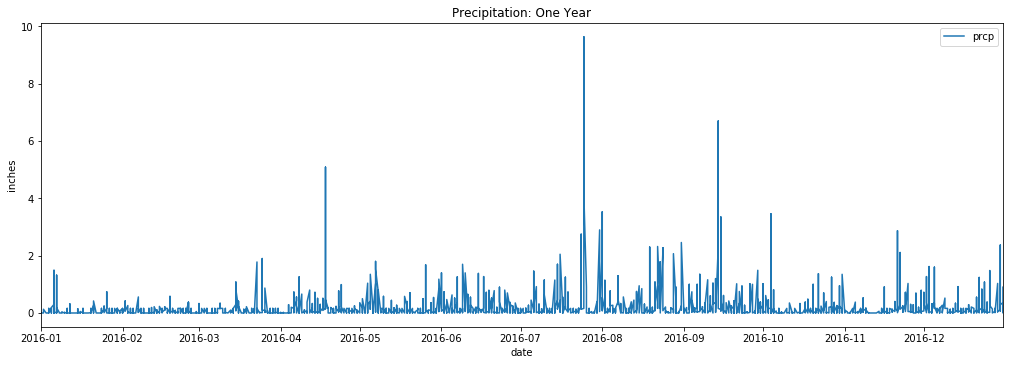

In [10]:
prcp.plot(x_compat = True, figsize =(14, 5) )
plt.tight_layout()
plt.title("Precipitation: One Year")
plt.ylabel("inches")
plt.savefig('Images/Precipitation')
plt.show()

### Precipitation Summary Statistics

In [11]:
prcp.describe()

,prcp
count,2309.000000
mean,0.177849
std,0.479349
min,0.000000
25%,0.000000
50%,0.040000
75%,0.160644
max,9.640000


# Station Analysis

In [12]:
print("Total Station Count: "+ str(session.query(stations.station).count()))

Total Station Count: 9


### Station by Observations Counts

In [13]:
ts = session.query(measurement.station, func.count(measurement.tobs)).\
       group_by(measurement.station).order_by(func.sum(measurement.tobs).desc()).all()
labels = ['Station', 'Observations']
top_stations = pd.DataFrame.from_records(ts, columns=labels)
top_stations

,Station,Observations
0,USC00519397,2724
1,USC00519523,2669
2,USC00519281,2772
3,USC00513117,2709
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


### Most Responsive Station in Dataset

In [14]:
top_station = session.query(stations.name).filter(stations.station == top_stations['Station'][0]).all()
print("Station with highest observation count: "+str(top_stations['Station'][0])+" :"+ str(top_station[0]))

Station with highest observation count: USC00519397 :('WAIKIKI 717.2, HI US',)


### Most Responsive Station for Past Year:  Histogram

In [15]:
this_year = session.query(measurement.station, func.count(measurement.tobs)).\
    filter(measurement.date >= '2016-01-01', measurement.date < '2017-01-01').\
    group_by(measurement.station).order_by(func.count(measurement.tobs).desc(),measurement.station.asc()).all()

In [16]:
top_year = pd.DataFrame(session.query(measurement.date,measurement.tobs).\
filter(measurement.station == this_year[0][0],\
       measurement.date >= '2016-01-01', measurement.date < '2017-01-01').all())

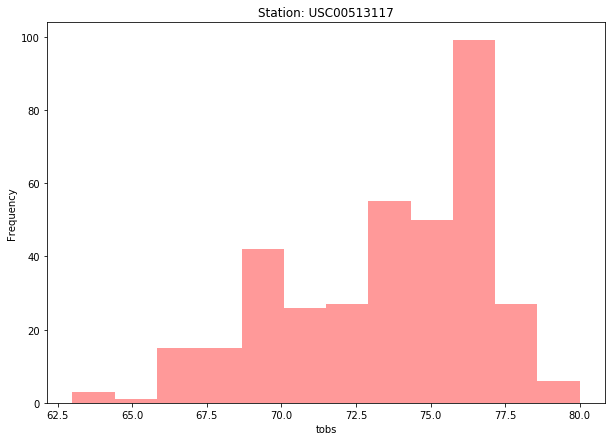

In [17]:
import seaborn as sns
fig, ax = pyplot.subplots(figsize=(10,7))
 
sns.distplot( ax=ax, a=top_year["tobs"],bins=12, hist=True, kde=False, rug=False,color="red" )
plt.title("Station: "+str(this_year[0][0]))
plt.ylabel('Frequency')
plt.savefig('Images/Station_Hist')
plt.show()


# Temperature Analysis

In [18]:
def calc_temps(start_date,end_date):
    data = pd.DataFrame(session.query(measurement.tobs).\
    filter(measurement.date >= (pd.to_datetime(start_date)- dt.timedelta(days=365)).date().strftime('%Y-%m-%d'), \
           measurement.date < (pd.to_datetime(end_date)- dt.timedelta(days=365)).date().strftime('%Y-%m-%d')).all())
    avg = round(data['tobs'].mean())
    low = data['tobs'].min()
    high = data['tobs'].max()
    print("Historical average temperature  for your vacation is: "+str(avg)+" degrees")
    print("Historical low temperature for your vacation is: "+str(low)+" degrees")
    print("Historical high temperature for your vacation is: "+str(high)+" degrees")
    return avg,low,high

In [19]:
start_date = str(input("What is the first day of your vacation: "))
end_date = str(input("What is the last day of your vacation: "))
print()
print()
average,low,high = calc_temps(start_date, end_date)

What is the first day of your vacation: 2018-06-01
What is the last day of your vacation: 2018-06-15


Historical average temperature  for your vacation is: 77 degrees
Historical low temperature for your vacation is: 72 degrees
Historical high temperature for your vacation is: 83 degrees


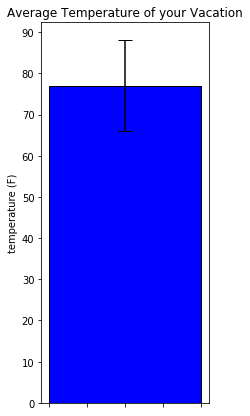

In [20]:
fig, ax = pyplot.subplots(figsize=(3,7))
ax.bar(1, average, color = 'blue', edgecolor = 'black', yerr=(high-low), capsize=7, label='test')
ax.set_xticklabels([])
plt.yticks(np.arange(0, average+20, 10))
plt.title ("Average Temperature of your Vacation")
plt.ylabel ("temperature (F)")
plt.savefig('Images/Vaca_Temp')
plt.show()